# Проект 5. Компьютер говорит «Нет» 

Цель проекта: Предсказать вероятность дефолта клиента банка 

In [1]:
# Импорт библиотек
from pandas import Series
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, auc, accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

## Дополнительные функции

In [2]:
# Функция возвращает квартили, выводит границы для выбросов,
# согласно IQR и считает сколько выбросов (в том числе в %)
def IQR_for_column(column):
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + \
        len(data[data[column] < min_out])
    print(
        '25-й перцентиль: {} |'.format(perc25),
        '75-й перцентиль: {} |'.format(perc75),
        "IQR: {} | ".format(IQR),
        "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(
        anomaly, anomaly/len(data)))


# Функция для постороения графика распределения значений одного столбца
def draw_histplot(column, bins='auto', discrete=False, kde=False):
    sns.set(font_scale=1.4)
    plt.figure(figsize=(18, 6))
    sns.histplot(data[column], discrete=discrete,
                 color='blue', bins=bins, kde=kde)


# Функция логарифмируем значения в столбце, рисует график нового распределения и выводит данные IQR
def draw_log_column(column):
    data[column] = np.log(data[column] + 1)
    IQR_for_column(column)
    draw_histplot(column, discrete=False)
    
    # Логарифмируем данный признак
    #data['age'] = np.log(data['age'] + 1)
    #IQR_for_column('age')
    #draw_histplot('age', discrete=False)
    

# Функция выводит различные метрики для оценки качества модели
def print_metrics(y_test, y_pred):
    print('accuracy_score: {}'.format(
        np.round(accuracy_score(y_test, y_pred), 4)))
    print('precision_score: {}'.format(
        np.round(precision_score(y_test, y_pred), 4)))
    print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
    print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))

# Функция выводит roc curve и confusion матрицу
def draw_roc_curve(y_test, y_proba, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.set(font_scale=1)
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.6g')

In [3]:
random = 42

In [4]:
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

## Посмотрим на данные

**Описания полей:**
* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы 
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* foreign_passport - наличие загранпаспорта
* first_time - давность наличия информации о заемщике
* default - флаг дефолта по кредиту

In [5]:
df_train.shape

(73799, 19)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
df_test.shape

(36349, 18)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [10]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [11]:
sample_submission.shape

(36349, 2)

In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [13]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train])# df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
data.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

In [17]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [18]:
# Посмотрим более полный отчет по датасету с помощью pandas-profiling
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df_train)
# profile.to_notebook_iframe()

Посмотрим пропуски


In [19]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [20]:
# Процент пропусков признака education
round(data.education.isna().sum() / data.shape[0]*100, 2)

0.43

Пропуски встречаются только в информации об образовании клиентов.


In [21]:
# Удалим малоинформативные признаки
data.drop(['client_id','app_date',], axis = 1, inplace=True)

## Признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа

In [22]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address']

## Изучим признаки

**Целевая переменная default. Посмотрим, каких клиентов у банка больше?**

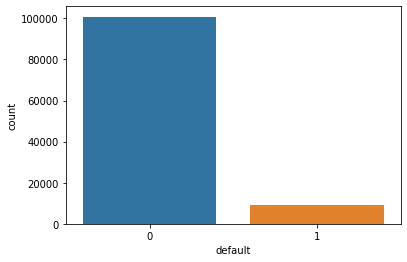

In [23]:
sns.countplot(x="default", data=data);

Поскольку выборка несбалансированная, то следует в качестве целевой использовать следующие метрики: precision, recall, F1-score. Они будут корректнее описывать алгоритм, чем accuracy.


## Числовые признаки

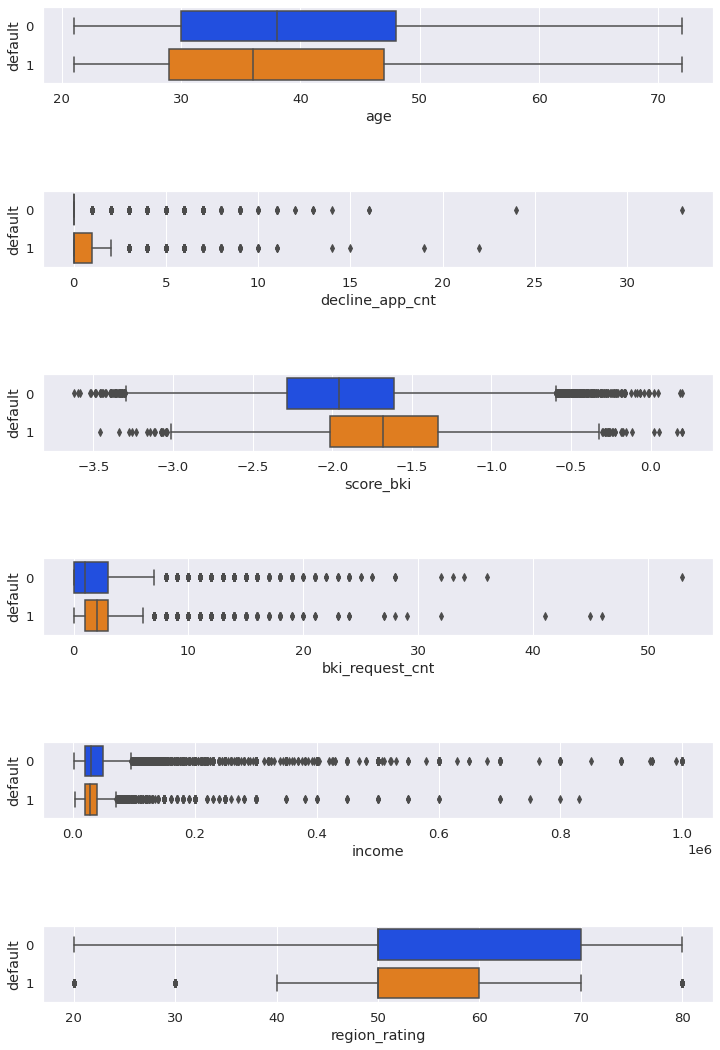

In [24]:
# Посмотрим зависимость целевой переменной от числовых признаков
# num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

sns.set(font_scale=1.2)
plt.subplots(figsize=(12, 20))
k = 1  
for col in num_cols:
    plt.subplot(12, 1, k)
    sns.boxplot(y=data[data['sample'] == 1].default,
                x=data[data['sample'] == 1][col], orient='h', palette='bright')
    k += 2

**Предварительных выводы:**
* Люди имеющие дефолт немного моложе
* Количество отказанных прошлых заявок больше у людей с дефолтом
* Скоринговый балл по данным из БКИ выше у людей с дефолтом
* Зарплата в среднем выше в людей без дефолта
* Количество запросов в БКИ в среднем выше у людей с дефолтом

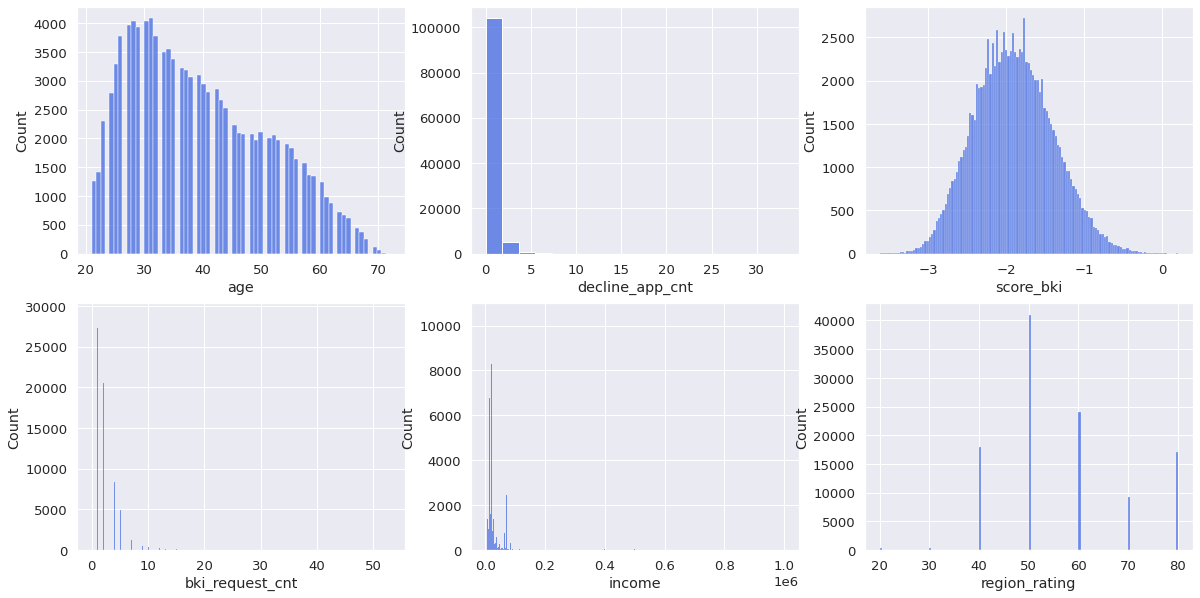

In [25]:
#  Визуализация - посмотрим распределение числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=False, ax=axes.flat[i], color='royalblue')

Некоторые графики имеют правый хвост. Посмотрим на каждый признак подробнее. 

### Age

25-й перцентиль: 30.0 | 75-й перцентиль: 48.0 | IQR: 18.0 |  Границы выбросов: [3.0, 75.0].
Выбросов, согласно IQR: 0 | 0.00%
None


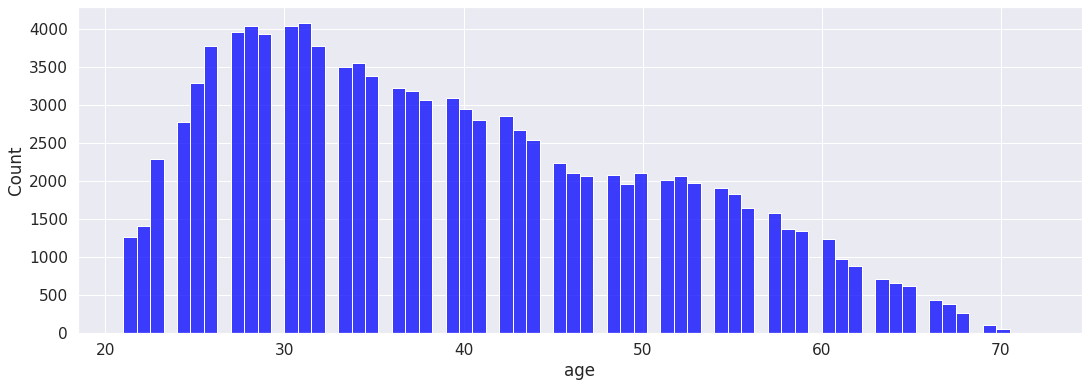

In [26]:
print(IQR_for_column('age'))
draw_histplot('age')

Логарифмирование сильно не помогло, оставим как есть


### decline_app_cnt

25-й перцентиль: 0.0 | 75-й перцентиль: 0.0 | IQR: 0.0 |  Границы выбросов: [0.0, 0.0].
Выбросов, согласно IQR: 18677 | 16.96%


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

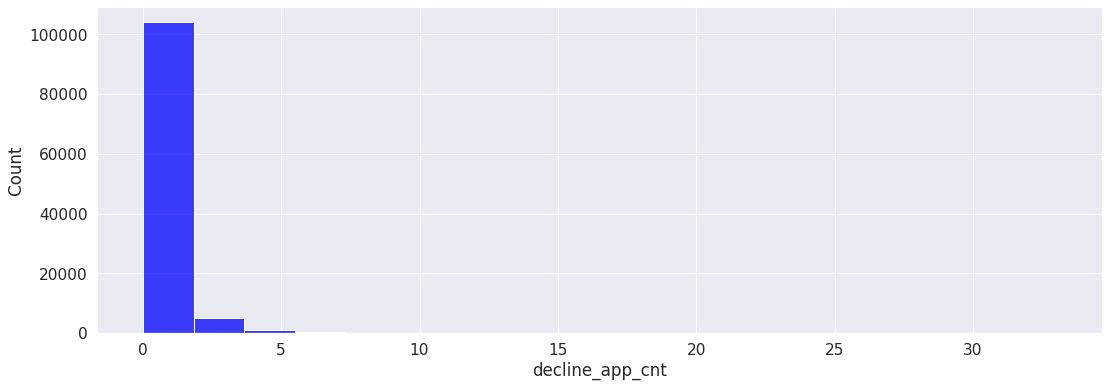

In [27]:
IQR_for_column('decline_app_cnt')
display(data.decline_app_cnt.value_counts())
draw_histplot('decline_app_cnt')

25-й перцентиль: 0.0 | 75-й перцентиль: 0.0 | IQR: 0.0 |  Границы выбросов: [0.0, 0.0].
Выбросов, согласно IQR: 18677 | 16.96%


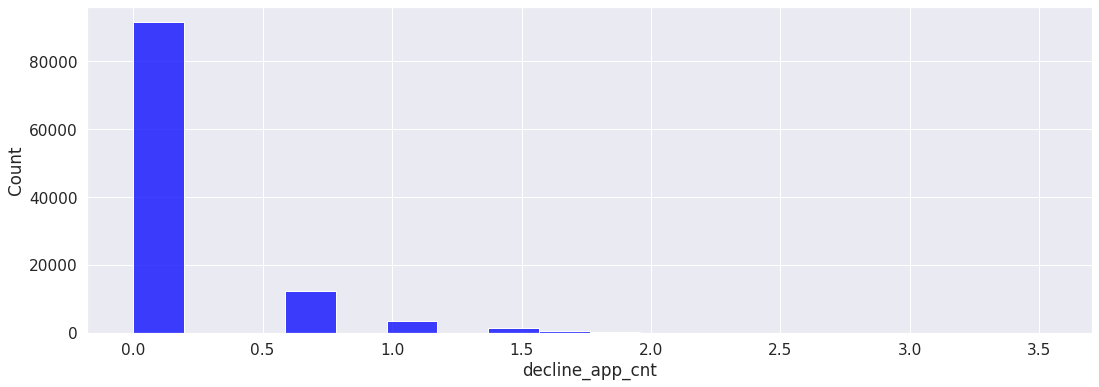

In [28]:
# Логарифмируем данный признак
draw_log_column('decline_app_cnt')


Рапределение стало немного лучше, хотя количество выбросов согласно IQR не уменьшилось


### score_bki

25-й перцентиль: -2.2604336700000003 | 75-й перцентиль: -1.5678881525 | IQR: 0.6925455175000004 |  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Выбросов, согласно IQR: 518 | 0.47%


-1.775263    517
-2.104211    454
-2.225004    424
-2.169664    375
-2.024100    278
            ... 
-1.524932      1
-1.927042      1
-2.006384      1
-1.904967      1
-1.764711      1
Name: score_bki, Length: 102618, dtype: int64

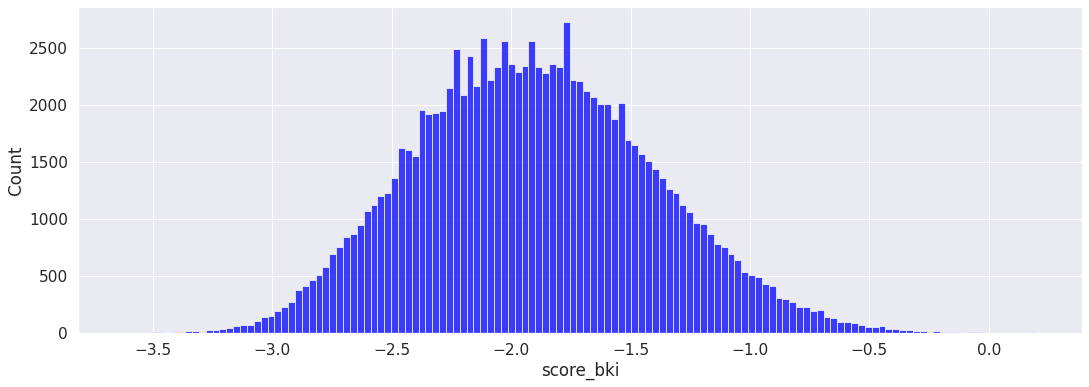

In [29]:
IQR_for_column('score_bki')
display(data.score_bki.value_counts())
draw_histplot('score_bki', discrete=False)

In [30]:
# Логарифмируем
# draw_log_column('score_bki')

При логарифмировании количество выбросов уменьшится, но распределение станет хуже. Оставим без изменения


### income

25-й перцентиль: 20000.0 | 75-й перцентиль: 48000.0 | IQR: 28000.0 |  Границы выбросов: [-22000.0, 90000.0].
Выбросов, согласно IQR: 7000 | 6.36%


30000     10437
25000      9090
20000      8174
40000      7383
50000      6742
          ...  
49700         1
14271         1
38100         1
426000        1
100600        1
Name: income, Length: 1207, dtype: int64

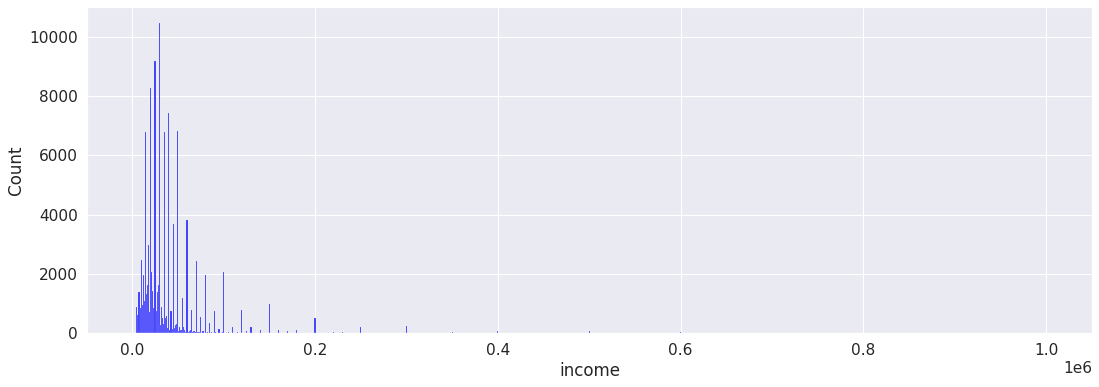

In [31]:
IQR_for_column('income')
display(data.income.value_counts())
draw_histplot('income', discrete=False)

25-й перцентиль: 9.90353755128617 | 75-й перцентиль: 10.778977123006351 | IQR: 0.8754395717201806 |  Границы выбросов: [8.590378193705899, 12.092136480586621].
Выбросов, согласно IQR: 2609 | 2.37%


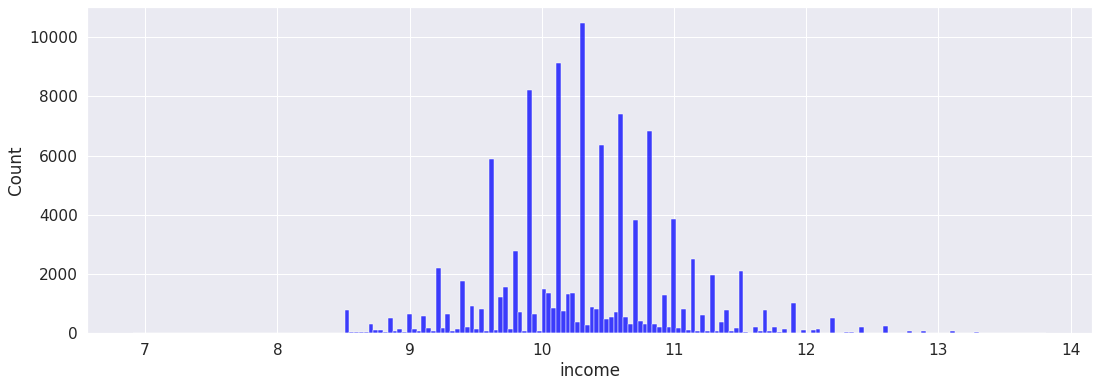

In [32]:
# Логарифмируем
draw_log_column('income')

Распределение стало напоминать нормальное. Почти в три раза уменьшилось количество выбросов


### bki_request_cnt

25-й перцентиль: 0.0 | 75-й перцентиль: 3.0 | IQR: 3.0 |  Границы выбросов: [-4.5, 7.5].
Выбросов, согласно IQR: 2636 | 2.39%
None


0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
28        5
25        5
27        5
26        4
32        4
29        3
33        2
40        2
47        1
34        1
36        1
53        1
45        1
41        1
46        1
Name: bki_request_cnt, dtype: int64

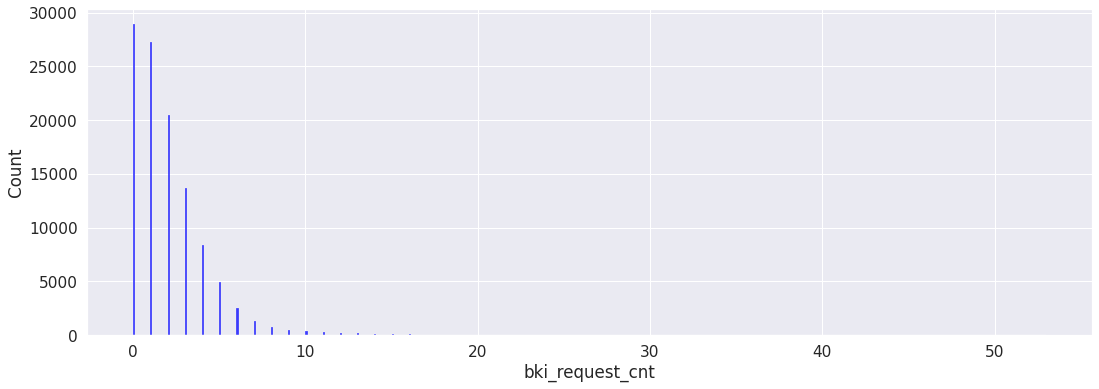

In [33]:
print(IQR_for_column('bki_request_cnt'))
display(data.bki_request_cnt.value_counts())
draw_histplot('bki_request_cnt')

25-й перцентиль: 0.0 | 75-й перцентиль: 1.3862943611198906 | IQR: 1.3862943611198906 |  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Выбросов, согласно IQR: 15 | 0.01%


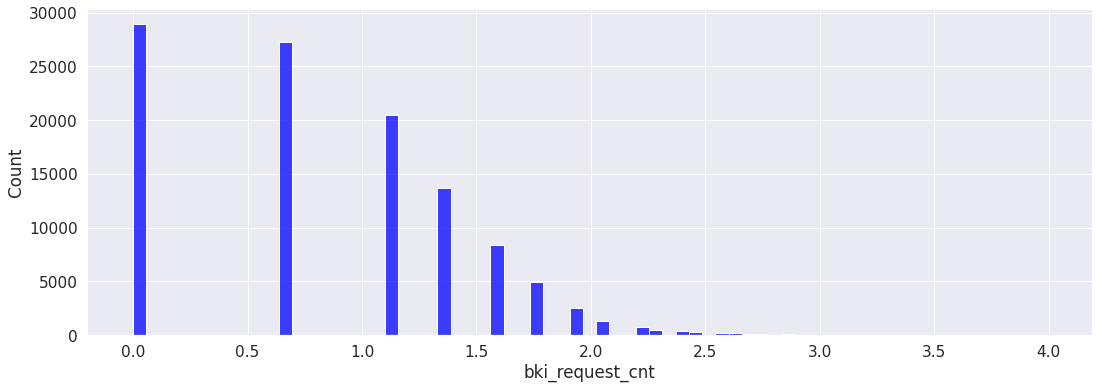

In [34]:
# Логарифмируем
draw_log_column('bki_request_cnt')

### region_rating

25-й перцентиль: 50.0 | 75-й перцентиль: 60.0 | IQR: 10.0 |  Границы выбросов: [35.0, 75.0].
Выбросов, согласно IQR: 17917 | 16.27%


50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

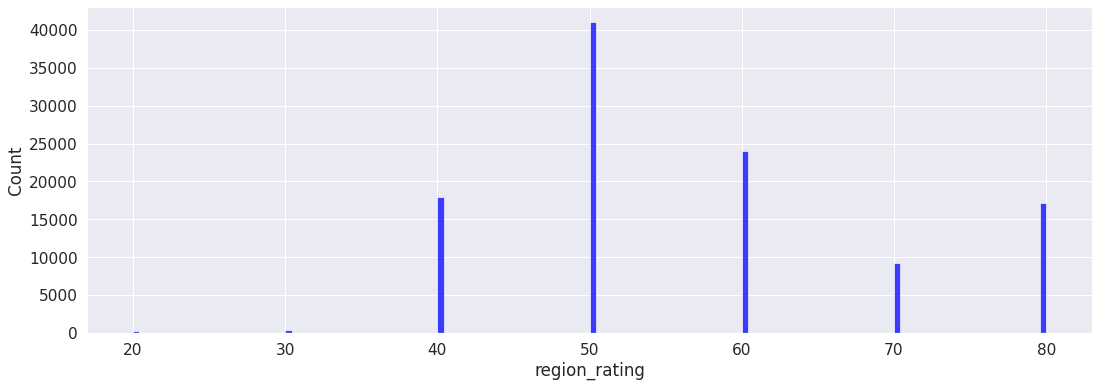

In [35]:
IQR_for_column('region_rating')
display(data.region_rating.value_counts())
draw_histplot('region_rating')

Распределение улучшилось. Почти все выбросы пропали.

### Мартица корреляции для числовых признаков

<AxesSubplot:>

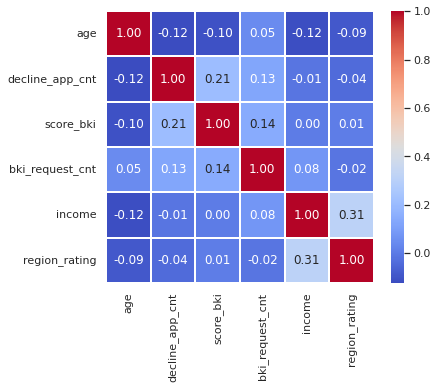

In [36]:
sns.set(font_scale=1)
plt.subplots(figsize=(6, 5))
sns.heatmap(data[num_cols].corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

Сильной зависимости между числовыми признаками нет

## Категориальные признаки

### education

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64
SCH    0.526546
GRD    0.315648
UGR    0.133893
PGR    0.016932
NaN    0.004340
ACD    0.002642
Name: education, dtype: float64


<AxesSubplot:title={'center':'Образование'}, xlabel='count', ylabel='education'>

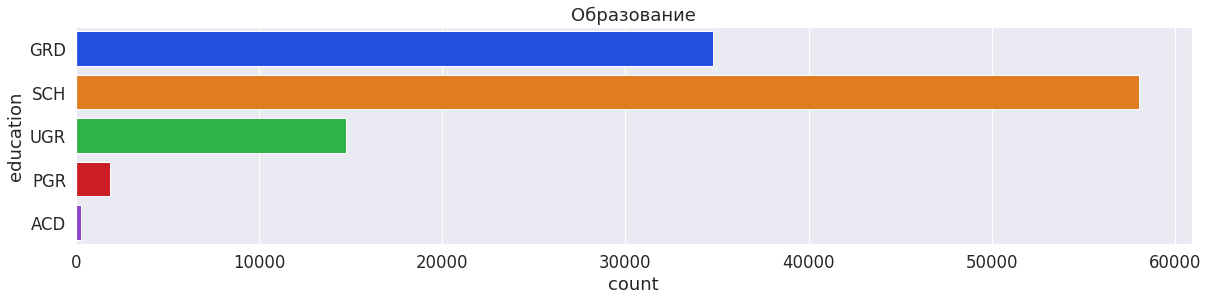

In [37]:
print(data.education.value_counts(dropna=False))
print(data.education.value_counts(dropna=False, normalize=True))

sns.set(font_scale=1.5)
plt.subplots(figsize=(20, 4))
plt.title('Образование')
sns.countplot(y="education", data=data, palette='bright')

Пропусков менее 5%

<AxesSubplot:xlabel='Count', ylabel='education'>

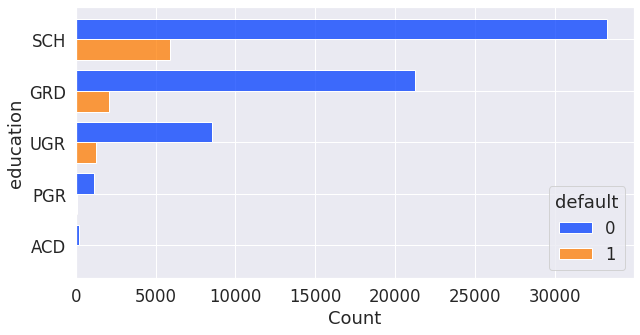

In [38]:
# Заменим пропуски на наиболее частое значение
data.education.fillna('SCH', inplace=True)
sns.set(font_scale=1.5)
plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data['sample'] == 1], y="education",
             hue="default", multiple="dodge", shrink=.8, palette='bright')

<AxesSubplot:xlabel='Count', ylabel='education'>

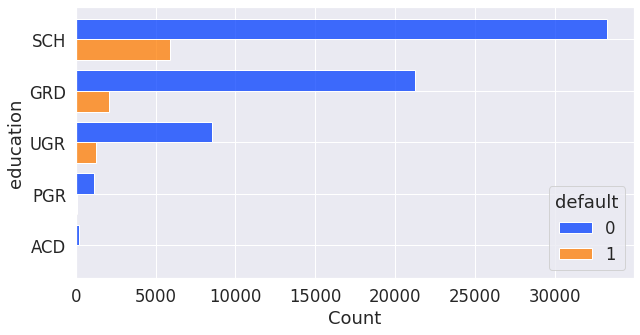

In [39]:
# Заменим пропуски на наиболее частое значение
data.education.fillna('SCH', inplace=True)
sns.set(font_scale=1.5)
plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data['sample'] == 1], y="education",
             hue="default", multiple="dodge", shrink=.8, palette='bright')

### work_address, home_address, sna, first_time

3    0.609298
2    0.279270
1    0.111432
Name: work_address, dtype: float64
2    0.541008
1    0.442023
3    0.016968
Name: home_address, dtype: float64
1    0.641691
4    0.158705
2    0.143734
3    0.055870
Name: sna, dtype: float64
3    0.422958
4    0.254358
1    0.166104
2    0.156580
Name: first_time, dtype: float64


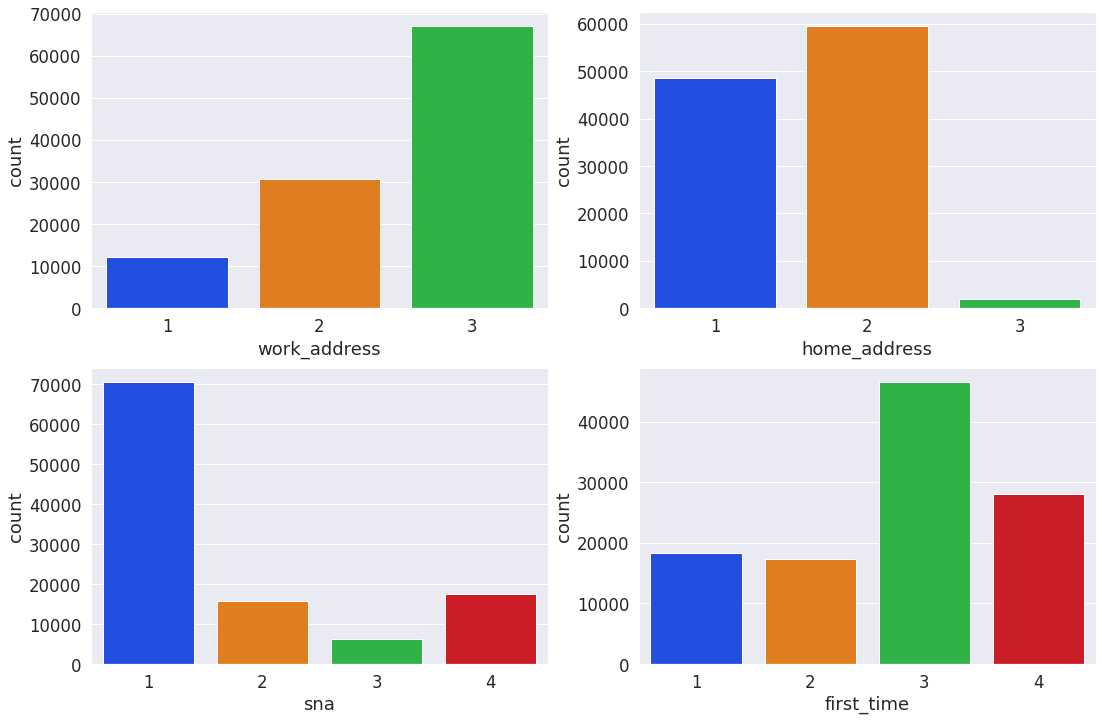

In [40]:
# Оставшиеся категориальные признаки
cat_col = ['work_address','home_address','sna','first_time'] 

for col in cat_col:
    print(data[col].value_counts(normalize=True))
    
plt.subplots(figsize=(18, 12))
for i,col in enumerate(cat_col):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=col, data=data, palette='bright')

## Бинарные признаки

In [41]:
# Перекодируем бинарные признаки и признак с образованием
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

keys_for_bin = {}
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    keys_for_bin[column] = dict(enumerate(le.classes_))

columns = ['first_time', 'sna', 'work_address',
           'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])
    
data['education'] = le.fit_transform(data['education'])  
keys_for_bin['education'] = dict(enumerate(le.classes_))
keys_for_bin  

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'},
 'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}}

## Значимость признаков

<AxesSubplot:>

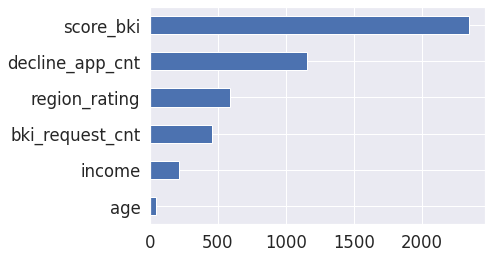

In [42]:
# Значимость для числовых признаков
temp_df = data[data['sample'] == 1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh')

Наиболее значим для целевой переменной score_bki, возраст менее значим

<AxesSubplot:>

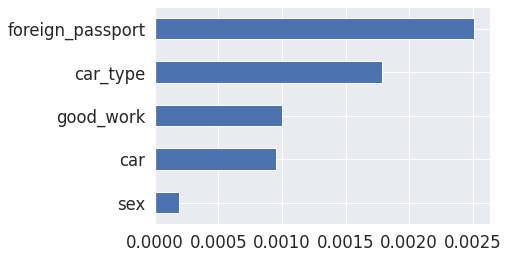

In [43]:
# Значимость для бинарных признаков
temp_df = data[data['sample'] == 1]
imp_bin = Series(mutual_info_classif(
    temp_df[bin_cols], temp_df['default'], discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind = 'barh')

Наибольшее значение имеют наличие загранпаспорта и тип авто. Пол влиет меньше всего

<AxesSubplot:>

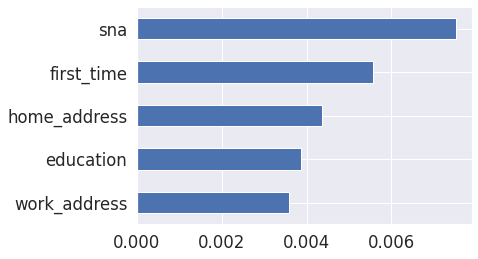

In [44]:
# Значимость для категориальных признаков
temp_df = data[data['sample'] == 1]
imp_cat = Series(mutual_info_classif(
    temp_df[cat_cols], temp_df['default'], discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [45]:
# Cделаем dummy-признаких 
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

## Простая модель

In [46]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

# Делим тренировочные данные на обучающуюся и проверочную
X = train_data.drop(['default'], axis=1)
y = train_data['default'].values 

In [47]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [48]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 21), (14760, 21), (59039,), (14760,))

In [49]:
# Обычная логистическая регрессия
model_1 = LogisticRegression(max_iter=1000)  
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
y_proba_1 = model_1.predict_proba(X_test)[:, 1]

accuracy_score: 0.875
precision_score: 0.0208
recall_score: 0.4043
f1_score: 0.0396


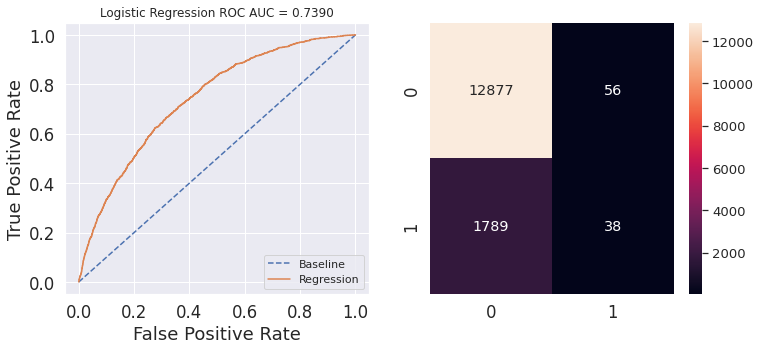

In [50]:
print_metrics(y_pred_1, y_test)
draw_roc_curve(y_test, y_proba_1, y_pred_1)

Хорошее значение ROC. 
Низкое значение f1_score и плохая confusion_matrix показывает, что мы 
почти всех клиентов относим к недефолтным. 

## Undersampling

In [51]:
# Внесем изменения в модель, применим Undersampling
# Делим тренировочные данные на обучающуюся и проверочную
X = train_data.drop(['default'], axis=1)
y = train_data['default']# .values 

# Сравняем  количество объектов разных классов 
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

# Посмотрим, сколько теперь объектов каждого класса
y_us.value_counts()

0    9372
1    9372
Name: default, dtype: int64

In [52]:
# Стандартизируем значения признаков и разбиваем выборку
X_us = StandardScaler().fit_transform(X_us)

X_train, X_test, y_train, y_test = train_test_split(
    X_us, y_us, test_size=0.20, random_state=42)

In [53]:
# Делаем обычную логистическую регрессию
model_2 = LogisticRegression(max_iter=2000)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
y_proba_2 = model_2.predict_proba(X_test)[:, 1]

accuracy_score: 0.6722
precision_score: 0.681
recall_score: 0.6663
f1_score: 0.6736


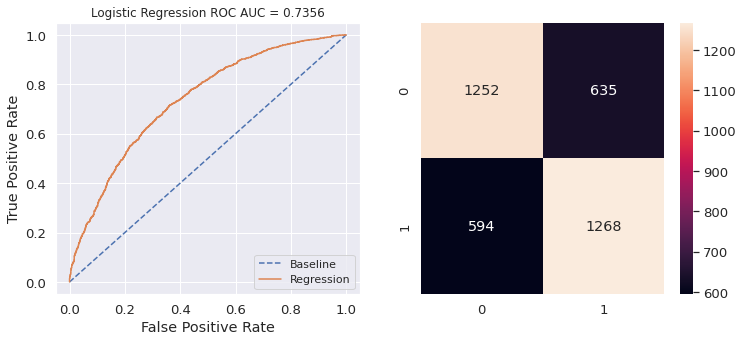

In [54]:
print_metrics(y_pred_2, y_test)
draw_roc_curve(y_test, y_proba_2, y_pred_2)

Уменьшилось значение ROC, но значения остальных метрик улучшилось, 
а f1-score стало значительно выше.

### Экспериментируем с гиперпараметрами

In [55]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(-3, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Укажем solver
model = LogisticRegression(max_iter=2000, solver='liblinear')
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 0.001


In [56]:
# Делаем логистическую регрессию с вычисленными параметрами
model_3 = LogisticRegression(max_iter=2000, 
                             C=best_model.best_estimator_.get_params()['C'], 
                             penalty=best_model.best_estimator_.get_params()['penalty'], 
                             solver='liblinear')
model_3.fit(X_train, y_train)
y_pred_3 = model_3.predict(X_test)
y_proba_3 = model_3.predict_proba(X_test)[:,1]

accuracy_score: 0.6764
precision_score: 0.6837
recall_score: 0.6711
f1_score: 0.6773


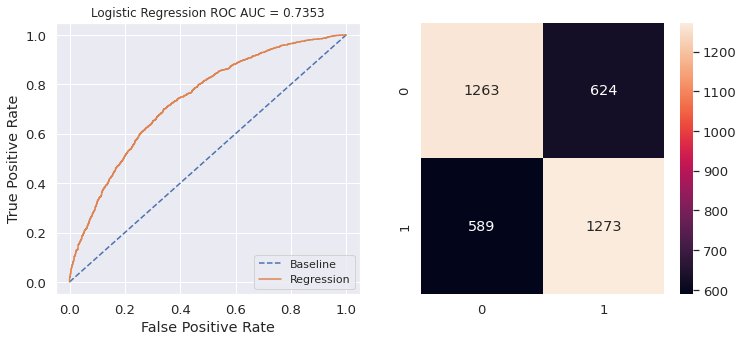

In [57]:
print_metrics(y_pred_3, y_test)
draw_roc_curve(y_test, y_proba_3, y_pred_3)

Для финального предсказания используем последнюю модель

In [58]:
X_sub = test_data.values
X_sub = StandardScaler().fit_transform(X_sub)
predict_submission = model_3.predict(X_sub)

In [59]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [60]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.494429
std,31706.052195,0.499976
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [61]:
 !kaggle competitions submit -c sf-scoring -f submission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
